In [101]:
import os
import sys
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
from collections import deque
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from itertools import count
import random
import scipy.stats as stats
from tqdm import tqdm
import math 
from simglucose.simulation.env import T1DSimEnv
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from simglucose.simulation.rendering import Viewer
from collections import namedtuple
from datetime import timedelta
from datetime import datetime
now = datetime.now()
start_time = datetime.combine(now.date(), datetime.min.time())

from DAAN572_Project.policies import ContinuousPolicy
from DAAN572_Project.utils import compute_loss
from DAAN572_Project.utils import CVGA_score

In [102]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# configure module & syspath
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

# set device    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [103]:
rewards_queue = deque()
rewards_ma = list()
run_duration = []
total_loss = []
state_lookback = 20
def get_num_params(lb):
    parms = (lb*3)+3
    return parms
num_state_features = get_num_params(state_lookback)
pi = ContinuousPolicy(63) 
pi.load_state_dict(torch.load('cont_policy_net3'))
pi.eval()


ContinuousPolicy(
  (linear1): Linear(in_features=63, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (mean): Linear(in_features=256, out_features=1, bias=True)
  (log_std): Linear(in_features=256, out_features=1, bias=True)
)

In [106]:
# pi.rewards = list()
# pi.log_probabilities = list()

In [368]:
patient = T1DPatient.withName('adolescent#001')
sensor = CGMSensor.withName('Dexcom', seed=1)
pump = InsulinPump.withName('Insulet')
env.reset()

scenario = CustomScenario(start_time=start_time, scenario=scen)
env = T1DSimEnv(patient, sensor, pump, scenario)
env.patient.observation


observation(Gsub=149.02)

In [369]:
max_trajectory_length = 100
discount_factor = 0.95
calories = 150
scen = [(1,calories), (5, calories), (9, calories*1.5), (13, calories), (17,calories), (21,calories)]


In [370]:

####################################
### INSTANTIATE OBSERVATION VARS ###
####################################

observation = env.patient.observation[0]
observation = ((env.patient.observation[0]-39))/400
observation_lag = observation
observation_change = observation - observation_lag        
observation_hist = np.zeros(state_lookback)
for i in range(state_lookback):
    observation_hist[i] = observation_change
observation_hist_norm = observation_hist


#######################################
### INSTANTIATE ACTION HISTORY VARS ###
#######################################
insulin = 0.025
insulin_norm = insulin / 30
insulin_lag = insulin_norm
insulin_hist = np.zeros(state_lookback)
for i in range(state_lookback):
    insulin_hist[i] = insulin_norm
insulin_hist_norm = insulin_hist


##############################################
### INSTANTIATE PLANNED MEAL HISTORY ARRAY ###
##############################################
planned_meal = env.patient.planned_meal
planned_meal_hist = np.zeros(state_lookback)
planned_meal_hist_norm = planned_meal_hist
planned_meal = 0
planned_meal_lag = 0


################################################
### INSTANTIATE CUSTOM REWARD FUNCTION ARRAY ###
################################################
CVGA_scores = []
running_bg = []
total_rewards = []
unobserved_CVGA_scores = np.zeros(8)    
for i in range(8):
    unobserved_CVGA_scores[i] = -65    

#################################
### INSTANTIATE CUR STATE VAR ###
#################################

state = np.concatenate((observation, observation_hist_norm, insulin_norm, insulin_hist_norm, planned_meal, planned_meal_hist_norm), axis=None).squeeze()


for t in range(max_trajectory_length):

    ########################
    ### DETERMINE ACTION ###
    ########################

    insulin = pi.act(torch.from_numpy(state.astype(np.float32)))


    ######################
    ### PERFORM ACTION ###
    ######################
    observation, reward, done, _ = env.step(insulin)  
    running_bg.append(observation)

    ##########################################
    ### POPULATE OBSERVATION HISTORY ARRAY ###
    ##########################################
    observation = (observation[0]-39)/400           # normalize glucose level to a value between 0 and 1
    observation_chg = observation - observation_lag   # create change value since previous time period
    observation_hist = np.roll(observation_hist,1)    # cycle the array by 1 position and move the oldest value from the rightmost position to first position
    observation_hist[0] = observation_chg             # replace first value in array (aka - the oldest value) with the most recent glucose change value
    observation_hist_norm = observation_hist     


    #####################################
    ### POPULATE ACTION HISTORY ARRAY ###
    #####################################
    insulin_norm = insulin / 30                       # normalize insulin val to restrict it to between 0 and 1
    insulin_chg = insulin_norm - insulin_lag               # create action change value since prev time period
    insulin_hist = np.roll(insulin_hist,1)            # cycle action array by 1 position move the oldest value from the rightmost position to the first position
    insulin_hist[0] = insulin_chg                     # replace first value in array (aka - the oldest value) with the most recent action change value
    insulin_hist_norm = insulin_hist

    
    ###########################################
    ### POPULATE PLANNED MEAL HISTORY ARRAY ###
    ###########################################
    planned_meal = env.patient.planned_meal        # extract planned meal value of current state
    planned_meal_chg = planned_meal - planned_meal_lag # create change value of planned meal since previous state
    planned_meal_hist = np.roll(planned_meal_hist,1)   # cycle planed meal array by 1 position move the oldest value from the rightmost position to the first position
    planned_meal_hist[0] = planned_meal_chg            # replace first value in array (aka - the oldest value) with the most recent action change value
    if np.max(planned_meal_hist) == 0:
        planned_meal_hist_norm = np.zeros(state_lookback)
    else:
        planned_meal_hist_norm = planned_meal_hist / np.linalg.norm(planned_meal_hist)     


    ####################################
    ### POPULATE CURRENT STATE ARRAY ###
    ####################################
    
    state = np.concatenate((observation,observation_hist_norm,insulin_norm,insulin_hist_norm,planned_meal,planned_meal_hist_norm),axis=None).squeeze()

    #####################################################
    ### MANIPULATE REWARDS VALUE WITH CUSTOM FUNCTION ###
    #####################################################
    
    variability_score = 0
    if t > 1 and t % 60 == 0:
        min_bg = np.percentile(running_bg, 2.5) 
        max_bg = np.percentile(running_bg, 97.5) 
        bg_range = (min_bg,max_bg)
        print(bg_range)
        variability_score = -CVGA_score(bg_range)
        period_idx = int(t/60) - 1
        unobserved_CVGA_scores[period_idx] = 0
        running_bg = []      

    if t == max_trajectory_length:
        done = TRUE
        reward = reward + sum(unobserved_CVGA_scores)  

    reward = reward + variability_score     

    
    #######################################
    ### APPEND REWARDS TO REWARDS ARRAY ###
    #######################################
    total_rewards.append(reward)


    ######################################################################
    ### REPOPULATE LAG VARS WITH CUR STATE VALS IN PREP OF NEXT ACTION ###
    ######################################################################
    observation_lag = observation
    planned_meal_lag = planned_meal
    insulin_lag = insulin_norm

           
print('Complete')



(136.82190103424796, 322.01306426206617)
Complete


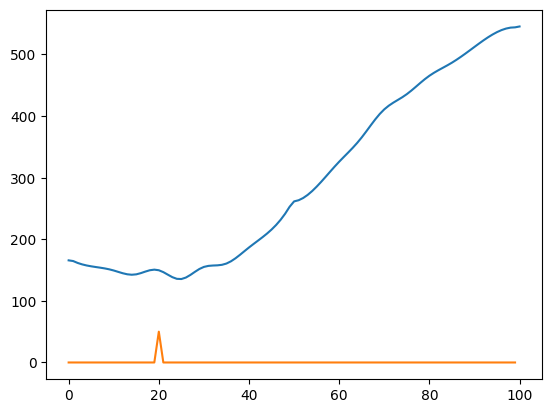

In [371]:
plt.plot(env.CGM_hist)
plt.plot(env.CHO_hist)

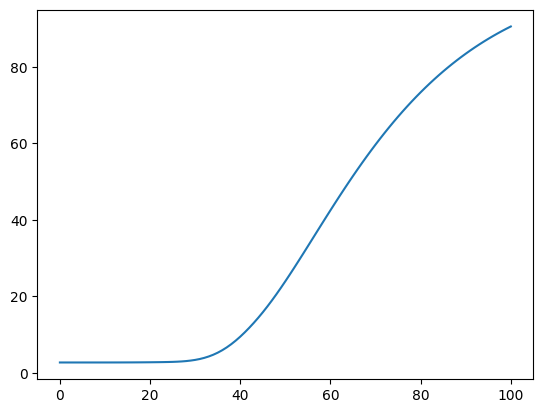

In [372]:
plt.plot(env.risk_hist)

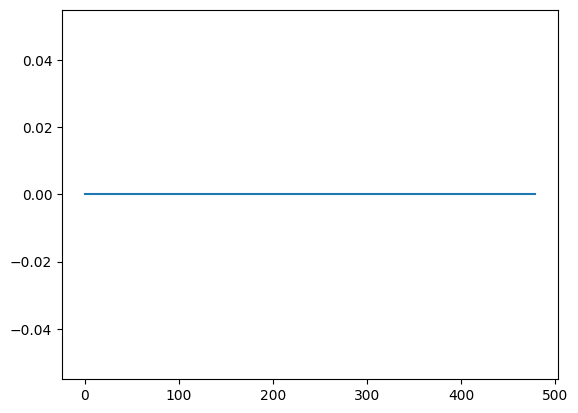

In [352]:
plt.plot(env.insulin_hist)

In [346]:
sum(total_rewards)

-489.1789987629125